## **Data Labeling and Model Training Mobile Legends: Bang Bang Review from Google Play Store**

#### **1. Import Library and Scraping Data**

In [41]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
import pickle

In [42]:
data = pd.read_csv("hasil_scraping.csv", index_col='ID')
data

,content
ID,
1,"game rusak, dapat tim gajelas padahal history ..."
2,bang bagus
3,game jelek banyak bug sama ketemunya rank gak ...
4,moonton ini kenapa kalo pake wifi aku main ran...
5,game taik. ubalah sistem jaringannya moonton s...
...,...
9996,wahh monton anj knpa gw selalu dapet tim lol
9997,jelek banget di beri bintang 1 aj GK pantas ap...
9998,game nya makin ngawur parah terutama matchmaki...


#### **2. Text Preprocessing**

In [43]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

##### **Removal Special Characters & Case Folding**

In [44]:
def remove_emoji(text):
    if text is not None and isinstance(text, str):
        emoji_pattern = re.compile(
            u"[\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F700-\U0001F77F"  # alchemical symbols
            u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA00-\U0001FA6F"  # Chess Symbols
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0001FC00-\U0001FCFF"  # Additional emoticons
            u"\U0001F1E0-\U0001F1FF"  # flags
            "]+", flags=re.UNICODE
        )
        return emoji_pattern.sub(r'', text)
    else:
        return text

def remove_URL(text):
    if text is not None and isinstance(text, str):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'', text)
    else:
        return text

def remove_html(text):
    if text is not None and isinstance(text, str):
        html = re.compile(r'<.*?>')
        return html.sub(r'', text)
    else:
        return text

def remove_symbols(text):
    if text is not None and isinstance(text, str):
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return text

def remove_numbers(text):
    if text is not None and isinstance(text, str):
        text = re.sub(r'\d','', text)
    return text

In [45]:
data['cleaning'] = data['content'].apply(remove_emoji)
data['cleaning'] = data['cleaning'].apply(remove_URL)
data['cleaning'] = data['cleaning'].apply(remove_html)
data['cleaning'] = data['cleaning'].apply(remove_symbols)
data['cleaning'] = data['cleaning'].apply(remove_numbers)
data['cleaning'] = data['cleaning'].str.lower()

##### **Removing Repeated Words (Max. 2 Words)**

In [46]:
def normalize_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [47]:
data['cleaning'] = data['cleaning'].apply(normalize_repeated_chars)
data

,content,cleaning
ID,,
1,"game rusak, dapat tim gajelas padahal history ...",game rusak dapat tim gajelas padahal history ...
2,bang bagus,bang bagus
3,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank gak ...
4,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalo pake wifi aku main ran...
5,game taik. ubalah sistem jaringannya moonton s...,game taik ubalah sistem jaringannya moonton s...
...,...,...
9996,wahh monton anj knpa gw selalu dapet tim lol,wahh monton anj knpa gw selalu dapet tim lol
9997,jelek banget di beri bintang 1 aj GK pantas ap...,jelek banget di beri bintang aj gk pantas apa...
9998,game nya makin ngawur parah terutama matchmaki...,game nya makin ngawur parah terutama matchmaki...


In [48]:
def replace_taboo_words(text, kamus_tidak_baku):
    if isinstance(text, str):
        words = text.split()
        replaced_words = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []

        for word in words:
            if word in kamus_tidak_baku:
                baku_word = kamus_tidak_baku[word]
                if isinstance(baku_word, str) and all(char.isalpha() for char in baku_word):
                    replaced_words.append(baku_word)
                    kalimat_baku.append(baku_word)
                    kata_diganti.append(word)
                    kata_tidak_baku_hash.append(hash(word))
            else:
                replaced_words.append(word)
        replaced_text = ' '.join(replaced_words)
    else:
        replaced_text = []
        kalimat_baku = []
        kata_diganti = []
        kata_tidak_baku_hash = []
    return replaced_text, kalimat_baku, kata_diganti, kata_tidak_baku_hash

##### **Formal Indonesian Vocabulary**

In [49]:
kamus_data = pd.read_excel("kamuskatabaku.xlsx")
kamus_tidak_baku = dict(zip(kamus_data['tidak_baku'],kamus_data['kata_baku']))

In [50]:
data['baku'], data['Kata_Baku'], data['Kata_Tidak_Baku'], data['Kata_Tidak_Baku_Hash'] = zip(*data['cleaning'].apply(lambda x: replace_taboo_words(x, kamus_tidak_baku)))

In [51]:
data = pd.DataFrame(data[['content', 'cleaning', 'baku']])
data

,content,cleaning,baku
ID,,,
1,"game rusak, dapat tim gajelas padahal history ...",game rusak dapat tim gajelas padahal history ...,game rusak dapat tim padahal history permainan...
2,bang bagus,bang bagus,abang bagus
3,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank tida...
4,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalau pakai wifi aku main r...
5,game taik. ubalah sistem jaringannya moonton s...,game taik ubalah sistem jaringannya moonton s...,game tahi ubalah sistem jaringannya moonton se...
...,...,...,...
9996,wahh monton anj knpa gw selalu dapet tim lol,wahh monton anj knpa gw selalu dapet tim lol,wah monton anjing kenapa gue selalu dapat tim lol
9997,jelek banget di beri bintang 1 aj GK pantas ap...,jelek banget di beri bintang aj gk pantas apa...,jelek banget di beri bintang saja tidak pantas...
9998,game nya makin ngawur parah terutama matchmaki...,game nya makin ngawur parah terutama matchmaki...,game ya makin ngawur parah terutama matchmakin...


##### **Tekonizing**

In [52]:
def tokenize(text):
    return word_tokenize(text)

In [53]:
data['tokenized'] = data['baku'].apply(tokenize)
data

,content,cleaning,baku,tokenized
ID,,,,
1,"game rusak, dapat tim gajelas padahal history ...",game rusak dapat tim gajelas padahal history ...,game rusak dapat tim padahal history permainan...,"[game, rusak, dapat, tim, padahal, history, pe..."
2,bang bagus,bang bagus,abang bagus,"[abang, bagus]"
3,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank tida...,"[game, jelek, banyak, bug, sama, ketemunya, ra..."
4,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalau pakai wifi aku main r...,"[moonton, ini, kenapa, kalau, pakai, wifi, aku..."
5,game taik. ubalah sistem jaringannya moonton s...,game taik ubalah sistem jaringannya moonton s...,game tahi ubalah sistem jaringannya moonton se...,"[game, tahi, ubalah, sistem, jaringannya, moon..."
...,...,...,...,...
9996,wahh monton anj knpa gw selalu dapet tim lol,wahh monton anj knpa gw selalu dapet tim lol,wah monton anjing kenapa gue selalu dapat tim lol,"[wah, monton, anjing, kenapa, gue, selalu, dap..."
9997,jelek banget di beri bintang 1 aj GK pantas ap...,jelek banget di beri bintang aj gk pantas apa...,jelek banget di beri bintang saja tidak pantas...,"[jelek, banget, di, beri, bintang, saja, tidak..."
9998,game nya makin ngawur parah terutama matchmaki...,game nya makin ngawur parah terutama matchmaki...,game ya makin ngawur parah terutama matchmakin...,"[game, ya, makin, ngawur, parah, terutama, mat..."


##### **Stopword Removal**

In [54]:
def stopwordremoval(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['min','nah','oh','iya','yaa','gak','nya','na','sih','si','ku',
                          "di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [55]:
data['stopword_removed'] = data['tokenized'].apply(lambda x: stopwordremoval(x))
data

##### **Stemming**

In [56]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    return [stemmer.stem(word) for word in text]

data['stemming'] = data['stopword_removed'].apply(lambda x: ' '.join(stem_text(x)))

In [ ]:
data

,content,cleaning,baku,tokenized,stopword_removed,stemming
ID,,,,,,
1,"game rusak, dapat tim gajelas padahal history ...",game rusak dapat tim gajelas padahal history ...,game rusak dapat tim padahal history permainan...,"[game, rusak, dapat, tim, padahal, history, pe...","[game, rusak, tim, history, permainan, unggul,...",game rusak tim history main unggul main solo k...
2,bang bagus,bang bagus,abang bagus,"[abang, bagus]","[abang, bagus]",abang bagus
3,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank gak ...,game jelek banyak bug sama ketemunya rank tida...,"[game, jelek, banyak, bug, sama, ketemunya, ra...","[game, jelek, bug, ketemunya, rank, sesuai, solo]",game jelek bug ketemu rank sesuai solo
4,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalo pake wifi aku main ran...,moonton ini kenapa kalau pakai wifi aku main r...,"[moonton, ini, kenapa, kalau, pakai, wifi, aku...","[moonton, pakai, wifi, main, rank, masuk, kred...",moonton pakai wifi main rank masuk kredit scor...
5,game taik. ubalah sistem jaringannya moonton s...,game taik ubalah sistem jaringannya moonton s...,game tahi ubalah sistem jaringannya moonton se...,"[game, tahi, ubalah, sistem, jaringannya, moon...","[game, tahi, ubalah, sistem, jaringannya, moon...",game tahi uba sistem jaring moonton tanding ge...
...,...,...,...,...,...,...
9996,wahh monton anj knpa gw selalu dapet tim lol,wahh monton anj knpa gw selalu dapet tim lol,wah monton anjing kenapa gue selalu dapat tim lol,"[wah, monton, anjing, kenapa, gue, selalu, dap...","[monton, anjing, gue, tim, lol]",monton anjing gue tim lol
9997,jelek banget di beri bintang 1 aj GK pantas ap...,jelek banget di beri bintang aj gk pantas apa...,jelek banget di beri bintang saja tidak pantas...,"[jelek, banget, di, beri, bintang, saja, tidak...","[jelek, banget, bintang, dark, sistem, tolong,...",jelek banget bintang dark sistem tolong baik t...
9998,game nya makin ngawur parah terutama matchmaki...,game nya makin ngawur parah terutama matchmaki...,game ya makin ngawur parah terutama matchmakin...,"[game, ya, makin, ngawur, parah, terutama, mat...","[game, ngawur, parah, matchmaking, solo, ketem...",game ngawur parah matchmaking solo ketemu part...


#### **3. Data Labelling**

In [57]:
positive_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
negative_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

In [98]:
positive_df = pd.read_csv(positive_lexicon_url, header=None, names=['word', 'score'])
negative_df = pd.read_csv(negative_lexicon_url, header=None, names=['word', 'score'])

positive_dict = dict(zip(positive_df['word'], positive_df['score']))
negative_dict = dict(zip(negative_df['word'], negative_df['score']))

manual_positive = {
    'bantu': 3,
    'bagus': 4,
    'bagus': 5,
    'mantap': 4,
    'terbaik': 5,
    'simpel': 3,
    'inovatif': 3,
    'lengkap': 2,
    'bug':-4,
    'lag':-3,
    'jelek':-4,
    'lama':-5,
    'tolol':-4,
    'lemot':-3,
    'rusak':-5,
    'banget':-2
}

lexicon_dict = {**negative_dict, **positive_dict, **manual_positive}

In [99]:
data['sentiment_score'] = data['stopword_removed'].apply(
    lambda tokens: sum(lexicon_dict.get(token, 0) for token in tokens)
)

In [100]:
def get_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['sentiment_score'].apply(get_sentiment)

In [101]:
data['sentiment'].value_counts()

sentiment
positive    5527
negative    3422
neutral     1051
Name: count, dtype: int64

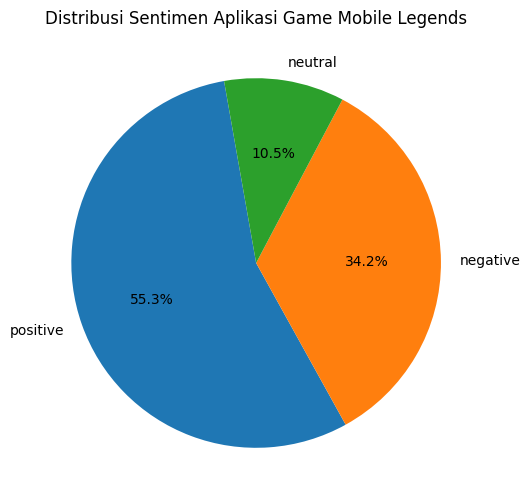

In [102]:
plt.figure(figsize=(8, 6))
plt.pie(data['sentiment'].value_counts(), labels=data['sentiment'].value_counts().index, autopct='%1.1f%%', startangle=100)
plt.title('Distribusi Sentimen Aplikasi Game Mobile Legends')
plt.show()

#### **4. Feature Extraction with TF-IDF**

In [103]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(data["stemming"])
ordinal = LabelEncoder()
y_tfidf = ordinal.fit_transform(data['sentiment'])

In [104]:
print("Vocabulary:", tfidf.vocabulary_)

Vocabulary: {'game': 1972, 'rusak': 5455, 'tim': 6381, 'history': 2447, 'main': 3631, 'unggul': 6626, 'solo': 5946, 'kasih': 2891, 'tolol': 6450, 'download': 1534, 'nih': 4558, 'katai': 2902, 'abang': 11, 'bagus': 424, 'jelek': 2706, 'bug': 883, 'ketemu': 3045, 'rank': 5251, 'sesuai': 5759, 'moonton': 4142, 'pakai': 4792, 'wifi': 6779, 'masuk': 3770, 'kredit': 3218, 'score': 5568, 'ngurang': 4542, 'update': 6644, 'kemarin': 2970, 'tolong': 6455, 'benerin': 618, 'tahi': 6170, 'uba': 6582, 'sistem': 5871, 'jaring': 2683, 'tanding': 6199, 'gejala': 2074, 'kadang': 2810, 'putus': 5206, 'tingkat': 6407, 'tarung': 6226, 'alam': 136, 'aneh': 201, 'data': 1243, 'ngelag': 4419, 'seru': 5734, 'ml': 4032, 'gua': 2263, 'beberapakali': 570, 'gem': 2089, 'mainin': 3634, 'login': 3473, 'tak': 6180, 'nama': 4287, 'mobillegin': 4078, 'babang': 394, 'malas': 3680, 'drak': 1559, 'musuh': 4233, 'jago': 2645, 'draksistem': 1562, 'pintar': 5005, 'ganteng': 2009, 'niat': 4548, 'bikin': 704, 'asih': 327, 'tea

In [105]:
print("TF-IDF Matrix:")
print(X_tfidf.toarray())

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [106]:
with open('l_ekstraksi fitur_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

#### **5. Modelling**

In [107]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

In [108]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.96:
            self.model.stop_training = True
custom_callback = Callback()

##### **SVM [TF-IDF, 75/25]**

In [109]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_tfidf, y_tfidf, test_size=0.25, stratify=y_tfidf, random_state=42)

In [110]:
svm_model = SVC()
svm_model.fit(X_train_svm, y_train_svm)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [111]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
}

grid_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svc,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_svc.fit(X_train_svm, y_train_svm)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'degree': [2, 3], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1


In [112]:
print("Best Parameters:", grid_svc.best_params_)

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [113]:
best_svc = grid_svc.best_estimator_

y_pred_train_svc_tfidf = best_svc.predict(X_train_svm)
y_pred_test_svc_tfidf = best_svc.predict(X_test_svm)

train_svm_tfidf = accuracy_score(y_train_svm, y_pred_train_svc_tfidf)
test_svm_tfidf = accuracy_score(y_test_svm, y_pred_test_svc_tfidf)

print("Train Accuracy:", train_svm_tfidf)
print("Test Accuracy :", test_svm_tfidf)

Train Accuracy: 0.9388
Test Accuracy : 0.8544


In [114]:
print("Classification Report (Test):")
print(classification_report(y_test_svm, y_pred_test_svc_tfidf))

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       855
           1       0.69      0.42      0.52       263
           2       0.87      0.93      0.90      1382

    accuracy                           0.85      2500
   macro avg       0.80      0.74      0.76      2500
weighted avg       0.85      0.85      0.85      2500



In [115]:
joblib.dump(svm_model, 'model_svm_tfidf.pkl')

['model_svm_tfidf.pkl']

##### **LSTM [Embedding-based Sequence Representation, 80/20]**

In [116]:
X = data['stemming']
le = LabelEncoder()
y_encoded = le.fit_transform(data['sentiment'])

X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(
    data['stemming'], y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [117]:
max_words = 5000
max_len = 100
tokenizer_LSTM = Tokenizer(num_words=max_words)
tokenizer_LSTM.fit_on_texts(X_train_LSTM)

X_train_LSTM = tokenizer_LSTM.texts_to_sequences(X_train_LSTM)
X_test_LSTM = tokenizer_LSTM.texts_to_sequences(X_test_LSTM)

X_train_LSTM = pad_sequences(X_train_LSTM, maxlen=max_len)
X_test_LSTM = pad_sequences(X_test_LSTM, maxlen=max_len)

y_train_LSTM = to_categorical(y_train_LSTM)
y_test_LSTM = to_categorical(y_test_LSTM)

In [118]:
with open('l_ekstraksi fitur_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer_LSTM, f)

In [119]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_words, 256, input_length=max_len))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [120]:
batch_size = 1028
history_LSTM = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=20,
    batch_size=batch_size,
    validation_data=(X_test_LSTM, y_test_LSTM),
    callbacks=[early_stopping]
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5046 - loss: 5.6528 - val_accuracy: 0.5530 - val_loss: 4.9405
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 888ms/step - accuracy: 0.5543 - loss: 4.5242 - val_accuracy: 0.5530 - val_loss: 3.9962
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 884ms/step - accuracy: 0.5530 - loss: 3.6612 - val_accuracy: 0.5530 - val_loss: 3.2402
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 913ms/step - accuracy: 0.5677 - loss: 2.9715 - val_accuracy: 0.5820 - val_loss: 2.6508
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 931ms/step - accuracy: 0.5922 - loss: 2.4289 - val_accuracy: 0.6045 - val_loss: 2.1697
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 903ms/step - accuracy: 0.6539 - loss: 1.9808 - val_accuracy: 0.6795 - val_loss: 1.7388
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 881ms/step - accuracy: 0.7075 - loss: 1.5981 - val_accuracy: 0.7045 - val_loss: 1.4342
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 952ms/step - accuracy: 0.7571 - loss: 1.2907 - val_accuracy: 0.7570 - val_loss: 

In [121]:
train_lstm = model_LSTM.evaluate(X_train_LSTM, y_train_LSTM, verbose=0)[1]
test_lstm = model_LSTM.evaluate(X_test_LSTM, y_test_LSTM, verbose=0)[1]

print("Train Accuracy:", train_lstm)
print("Test Accuracy :", test_lstm)

Train Accuracy: 0.9541249871253967
Test Accuracy : 0.862500011920929


In [122]:
model_LSTM.save("model_lstm.h5")

##### **MLP [TF-IDF, 70/30]**

In [123]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_tfidf, test_size=0.3, random_state=42, stratify=y_tfidf
)

In [124]:
y_train_dl = to_categorical(y_train_tfidf)
y_test_dl = to_categorical(y_test_tfidf)

model_mlp = Sequential()
model_mlp.add(Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(256, activation='relu'))
model_mlp.add(Dropout(0.3))
model_mlp.add(Dense(3, activation='softmax'))

model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_mlp.fit(
    X_train_tfidf, y_train_dl,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_tfidf, y_test_dl),
    callbacks=[early_stopping]
)

c:\Users\ACER\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7047 - loss: 0.6847 - val_accuracy: 0.8113 - val_loss: 0.4634
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8734 - loss: 0.3368 - val_accuracy: 0.8520 - val_loss: 0.4197
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9347 - loss: 0.1970 - val_accuracy: 0.8470 - val_loss: 0.4465
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9630 - loss: 0.1216 - val_accuracy: 0.8440 - val_loss: 0.5003
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9746 - loss: 0.0845 - val_accuracy: 0.8347 - val_loss: 0.5421


In [125]:
y_pred_train_mlp = model_mlp.predict(X_train_tfidf)
y_pred_test_mlp = model_mlp.predict(X_test_tfidf)

y_pred_train_labels = y_pred_train_mlp.argmax(axis=1)
y_pred_test_labels = y_pred_test_mlp.argmax(axis=1)
y_train_true_labels = y_train_dl.argmax(axis=1)
y_test_true_labels = y_test_dl.argmax(axis=1)

train_mlp = accuracy_score(y_train_true_labels, y_pred_train_labels)
test_mlp = accuracy_score(y_test_true_labels, y_pred_test_labels)

print("Train Accuracy:", train_mlp)
print("Test Accuracy :", test_mlp)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train Accuracy: 0.9514285714285714
Test Accuracy : 0.852


In [126]:
model_mlp.save("model_mlp.h5")

##### **Barchart of Model Accuracy**

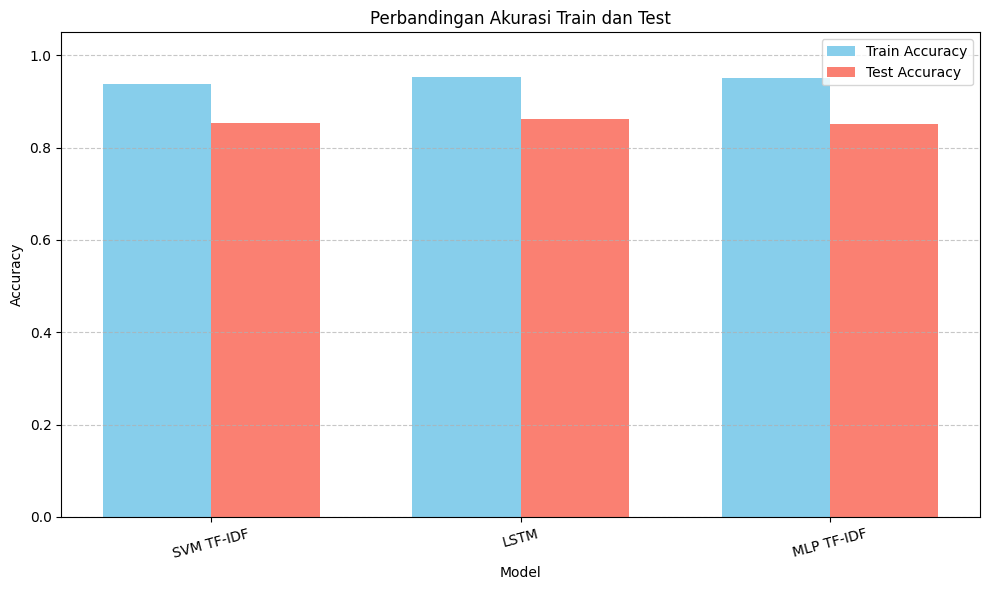

In [127]:
labels = ["SVM TF-IDF", "LSTM", "MLP TF-IDF"]
train_scores = [train_svm_tfidf, train_lstm, train_mlp]
test_scores = [test_svm_tfidf, test_lstm, test_mlp]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, train_scores, width=width, label="Train Accuracy", color='skyblue')
plt.bar([i + width for i in x], test_scores, width=width, label="Test Accuracy", color='salmon')

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Perbandingan Akurasi Train dan Test")
plt.xticks([i + width / 2 for i in x], labels, rotation=15)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [128]:
labels = ["SVM TF-IDF", "LSTM", "MLP TF-IDF"]
train_scores = [train_svm_tfidf, train_lstm, train_mlp]
test_scores = [test_svm_tfidf, test_lstm, test_mlp]

df_akurasi = pd.DataFrame({
    "Model": labels,
    "Train Accuracy": train_scores,
    "Test Accuracy": test_scores
})

df_akurasi

,Model,Train Accuracy,Test Accuracy
0,SVM TF-IDF,0.938800,0.8544
1,LSTM,0.954125,0.8625
2,MLP TF-IDF,0.951429,0.8520


#### **6. Data Testing**

In [138]:
ulasan = ["Terlalu banyak bug dan sering lag", "Hero barunya sudah rilis", "Game ini sangat seru dan grafiknya bagus"]
label_asli = ["negative", "neutral", "positive"]

ulasan_tfidf = tfidf.transform(ulasan)

ulasan_seq = tokenizer_LSTM.texts_to_sequences(ulasan)
ulasan_pad = pad_sequences(ulasan_seq, maxlen=100)

In [139]:
pred_svm_tfidf = best_svc.predict(ulasan_tfidf)
pred_lstm = model_LSTM.predict(ulasan_pad)
pred_lstm = np.argmax(pred_lstm, axis=1)
pred_mlp = model_mlp.predict(ulasan_tfidf.toarray())
pred_mlp = np.argmax(pred_mlp, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [140]:
for i, text in enumerate(ulasan):
    print(f"\nUlasan: {text}")
    print(f"Label Asli    : {label_asli[i]}")
    print("SVM TF-IDF    :", ordinal.inverse_transform([pred_svm_tfidf[i]])[0])
    print("LSTM          :", ordinal.inverse_transform([pred_lstm[i]])[0])
    print("MLP TF-IDF    :", ordinal.inverse_transform([pred_mlp[i]])[0])


Ulasan: Terlalu banyak bug dan sering lag
Label Asli    : negative
SVM TF-IDF    : negative
LSTM          : negative
MLP TF-IDF    : negative

Ulasan: Hero barunya sudah rilis
Label Asli    : neutral
SVM TF-IDF    : positive
LSTM          : neutral
MLP TF-IDF    : positive

Ulasan: Game ini sangat seru dan grafiknya bagus
Label Asli    : positive
SVM TF-IDF    : positive
LSTM          : positive
MLP TF-IDF    : positive


#### **7. Conclusion and Recommendations**

##### **Conclusion**

###### Based on the accuracy comparison, the LSTM model achieved the highest test accuracy at 86.25%, slightly outperforming SVM TF-IDF (85.44%) and MLP TF-IDF (85.20%). All models were able to classify clearly positive and negative reviews consistently. However, for short and informative reviews, traditional TF-IDF-based models sometimes misclassified neutral sentiments as positive. Overall, the deep learning approach (LSTM) proved more effective in capturing contextual meaning from user comments.

##### **Recommendations**

###### For future improvements, it is recommended to apply better handling of neutral reviews and enhance text preprocessing, especially normalization of Indonesian slang and gaming terms. Additional techniques such as regularization, data augmentation, or pre-trained embeddings can also be explored to further improve generalization and reduce overfitting.